# Bibliotheken/Einlesen

In [72]:
import numpy as np
import pandas as pd
import missingno as msno
from sklearn import linear_model, metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
df_test1 = pd.read_parquet("../Daten/energy_test1.parquet")
df_test2 = pd.read_parquet("../Daten/energy_test2.parquet")
df_train = pd.read_parquet("../Daten/energy_train.parquet")
df_forecasts = pd.read_parquet("../Daten/forecasts.parquet")

In [7]:
df_test1

,dtm,ref_datetime,Solar_capacity_mwp
0,2023-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423
1,2023-01-01 01:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423
2,2023-01-01 02:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423
3,2023-01-01 03:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423
4,2023-01-01 04:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423
...,...,...,...
7268,2023-10-30 20:00:00+00:00,2023-10-29 18:00:00+00:00,2452.979156
7269,2023-10-30 21:00:00+00:00,2023-10-29 18:00:00+00:00,2452.979156
7270,2023-10-30 22:00:00+00:00,2023-10-29 18:00:00+00:00,2452.979156
7271,2023-10-30 23:00:00+00:00,2023-10-29 18:00:00+00:00,2452.950587


In [8]:
df_test1.dtypes

dtm                   datetime64[ns, UTC]
ref_datetime          datetime64[ns, UTC]
Solar_capacity_mwp                float64
dtype: object

In [10]:
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7245 entries, 0 to 7272
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   dtm                 7245 non-null   datetime64[ns, UTC]
 1   ref_datetime        7245 non-null   datetime64[ns, UTC]
 2   Solar_capacity_mwp  7245 non-null   float64            
dtypes: datetime64[ns, UTC](2), float64(1)
memory usage: 226.4 KB


In [22]:
df_test2

,dtm,ref_datetime,Solar_capacity_mwp
0,2023-10-31 01:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019
1,2023-10-31 02:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019
2,2023-10-31 03:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019
3,2023-10-31 04:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019
4,2023-10-31 05:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019
...,...,...,...
9330,2024-11-22 19:00:00+00:00,2024-11-21 18:00:00+00:00,2776.562944
9331,2024-11-22 20:00:00+00:00,2024-11-21 18:00:00+00:00,2776.562903
9332,2024-11-22 21:00:00+00:00,2024-11-21 18:00:00+00:00,2776.562872
9333,2024-11-22 22:00:00+00:00,2024-11-21 18:00:00+00:00,2776.562858


In [23]:
df_test2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7465 entries, 0 to 9334
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   dtm                 7465 non-null   datetime64[ns, UTC]
 1   ref_datetime        7465 non-null   datetime64[ns, UTC]
 2   Solar_capacity_mwp  7465 non-null   float64            
dtypes: datetime64[ns, UTC](2), float64(1)
memory usage: 233.3 KB


In [51]:
df_train

,dtm,ref_datetime,Solar_capacity_mwp,Solar_MWh,date
0,2020-09-21 00:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,2020-09-21
1,2020-09-21 01:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,2020-09-21
2,2020-09-21 02:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,2020-09-21
3,2020-09-21 03:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,2020-09-21
4,2020-09-21 04:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,2020-09-21
...,...,...,...,...,...
19963,2022-12-31 19:00:00+00:00,2022-12-30 18:00:00+00:00,2212.678300,0.0,2022-12-31
19964,2022-12-31 20:00:00+00:00,2022-12-30 18:00:00+00:00,2212.678300,0.0,2022-12-31
19965,2022-12-31 21:00:00+00:00,2022-12-30 18:00:00+00:00,2212.678300,0.0,2022-12-31
19966,2022-12-31 22:00:00+00:00,2022-12-30 18:00:00+00:00,2212.678300,0.0,2022-12-31


In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19968 entries, 0 to 19967
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   dtm                 19968 non-null  datetime64[ns, UTC]
 1   ref_datetime        19968 non-null  datetime64[ns, UTC]
 2   Solar_capacity_mwp  19968 non-null  float64            
 3   Solar_MWh           19964 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(2)
memory usage: 624.1 KB


In [26]:
# TODO Zeilen anpassen (durchschnitt, vorheriger Wert) oder löschen
df_train[df_train.Solar_MWh.isna()] # empfohlen

,dtm,ref_datetime,Solar_capacity_mwp,Solar_MWh
19255,2022-12-02 07:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659752,NaN
19256,2022-12-02 08:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659763,NaN
19257,2022-12-02 09:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659763,NaN
19258,2022-12-02 10:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659763,NaN


In [28]:
df_forecasts

,ref_datetime,valid_time,SolarDownwardRadiation,CloudCover,Temperature,Weather Model
0,2020-09-20 00:00:00+00:00,20,-0.010547,0.366211,13.823755,DWD ICON
1,2020-09-20 00:00:00+00:00,21,0.001263,0.471512,13.427564,DWD ICON
2,2020-09-20 00:00:00+00:00,22,0.001532,0.398212,13.093005,DWD ICON
3,2020-09-20 00:00:00+00:00,23,-0.001624,0.292247,12.667871,DWD ICON
4,2020-09-20 00:00:00+00:00,24,-0.008356,0.327759,12.216522,DWD ICON
...,...,...,...,...,...,...
606792,2024-11-24 06:00:00+00:00,68,1.820000,1.000000,2.050000,NCEP GFS
606793,2024-11-24 06:00:00+00:00,69,0.930000,1.000000,2.700000,NCEP GFS
606794,2024-11-24 06:00:00+00:00,70,0.050000,1.000000,3.130000,NCEP GFS
606795,2024-11-24 06:00:00+00:00,71,0.000000,1.000000,3.560000,NCEP GFS


In [29]:
df_forecasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606797 entries, 0 to 606796
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   ref_datetime            606797 non-null  datetime64[ns, UTC]
 1   valid_time              606797 non-null  int64              
 2   SolarDownwardRadiation  605571 non-null  float64            
 3   CloudCover              606422 non-null  float64            
 4   Temperature             606494 non-null  float64            
 5   Weather Model           606797 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(1)
memory usage: 27.8+ MB


In [11]:
df_forecasts[df_forecasts.SolarDownwardRadiation.isna()] # empfohlen

,ref_datetime,valid_time,SolarDownwardRadiation,CloudCover,Temperature,Weather Model
4770,2020-10-13 06:00:00+00:00,20,NaN,NaN,NaN,DWD ICON
4771,2020-10-13 06:00:00+00:00,21,NaN,NaN,NaN,DWD ICON
4772,2020-10-13 06:00:00+00:00,22,NaN,NaN,NaN,DWD ICON
4773,2020-10-13 06:00:00+00:00,23,NaN,NaN,NaN,DWD ICON
4774,2020-10-13 06:00:00+00:00,24,NaN,NaN,NaN,DWD ICON
...,...,...,...,...,...,...
319956,2021-03-26 18:00:00+00:00,68,NaN,0.0,16.884634,NCEP GFS
319957,2021-03-26 18:00:00+00:00,69,NaN,0.0,16.942698,NCEP GFS
319958,2021-03-26 18:00:00+00:00,70,NaN,0.0,16.250010,NCEP GFS
319959,2021-03-26 18:00:00+00:00,71,NaN,0.0,15.012726,NCEP GFS


# Umgang mit NaN-Werten

__Umgang mit NaN-Werten in df_train__
- Betroffene Zeilen 4 von 19968 (ca.0,02%)
- Mein Ansatz: Zeilen, wo bei `Solar_MWh` NaN auftaucht, löschen

In [13]:
df_train = df_train.dropna(subset=["Solar_MWh"])

**Umgang mit NaN-Werten in df_forecasts**
- Betroffene Zeilen: max. 1226 von 606797 (ca. 0,2%)
- Mein Ansatz: Daten behalten und Auffüllen

In [15]:
# Spalte SolarDownwardRadiation
df_forecasts["SolarDownwardRadiation"] = df_forecasts["SolarDownwardRadiation"].interpolate(method="linear")

# Spalte CloudCover
df_forecasts["CloudCover"] = df_forecasts["CloudCover"].fillna(df_forecasts["CloudCover"].median())

# Spalte Temperature
df_forecasts["Temperature"] = df_forecasts["Temperature"].interpolate(method="linear")

**Validierung nach der Bereinigung**

In [16]:
print("NaN-Werte in df_train:", df_train.isna().sum())
print("NaN-Werte in df_forecasts:", df_forecasts.isna().sum())

NaN-Werte in df_train: dtm                   0
ref_datetime          0
Solar_capacity_mwp    0
Solar_MWh             0
dtype: int64
NaN-Werte in df_forecasts: ref_datetime              0
valid_time                0
SolarDownwardRadiation    0
CloudCover                0
Temperature               0
Weather Model             0
dtype: int64


# Aufgabe 1 Untersuchung der Energiedaten

In [18]:
# 1. Wie viele Datenpunkte, die vorhergesagt werden sollen, gibt es in den Trainings- bzw. Testdaten?
train_points = len(df_train)

# Anzahl der Datenpunkte in den beiden Testsets
test1_points = len(df_test1)
test2_points = len(df_test2)

print(f"Trainingsdatenpunkte: {train_points}")
print(f"Testdatenpunkte - Test1: {test1_points}, Test2: {test2_points}")

Trainingsdatenpunkte: 19964
Testdatenpunkte - Test1: 7245, Test2: 7465


In [ ]:
df_train

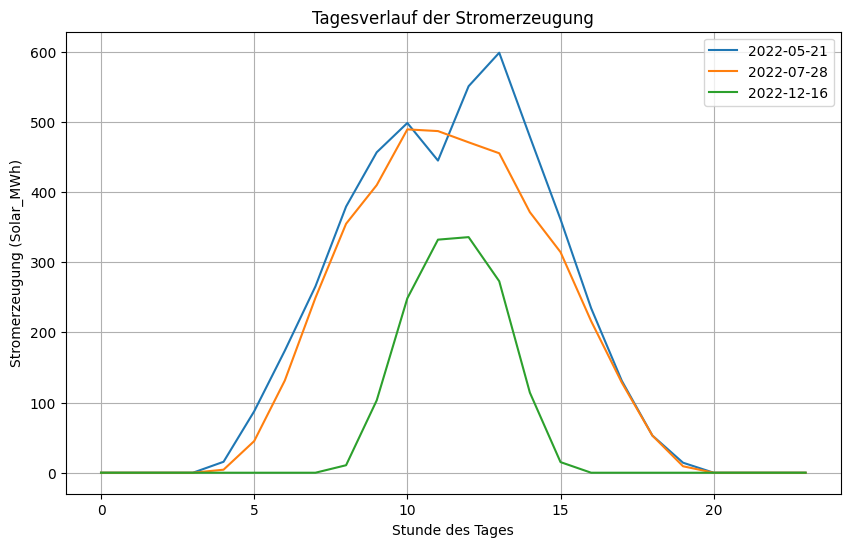

In [67]:
# 2. Tagesverlauf visualisieren
# (Zufälige)Geburtstage auswählen, bzw. Frühlings-, Sommer- und Winterzeit
birthdates = ["2022-05-21", "2022-07-28", "2022-12-16"]
birthdates = pd.to_datetime(birthdates) # Strings in datetime umwandeln

df_train["date"] = pd.to_datetime(df_train["dtm"]).dt.date  # Extrahiere das Datum

# Filter für die ausgewählten Tage
filtered_data = df_train[df_train["date"].isin(birthdates.date)]

# Plot
plt.figure(figsize=(10, 6))
for date in birthdates:
    daily_data = filtered_data[filtered_data["date"] == date.date()]
    plt.plot(
        pd.to_datetime(daily_data["dtm"]).dt.hour,
        daily_data["Solar_MWh"],
        label=str(date.date())
    )
plt.xlabel("Stunde des Tages")
plt.ylabel("Stromerzeugung (Solar_MWh)")
plt.title("Tagesverlauf der Stromerzeugung")
plt.legend()
plt.grid()
plt.show()

2022-05-21  Frühling <br>
2022-07-28 -> Sommer <br>
2022-12-16 -> Winter <br>
Man erkennt deutlich, dass logischerweise Nachts kein Strom produziert wird und der Tag der wichtige Teil für die Stromerzeugung. Auch erkennbar ist, dass der Winter weniger Strom produziert, was sehr stark an der Wolkenbedeckung liegen kann und die Tageszeit kürzer anhält als Frühling und Sommer.
Einen kleinen Ausreißer erkennt man beim Frühling, was bei ca. 10-12Uhr kurz wenig Strom produziert. Das könnte an einem Regenschauer liegen oder anderen technischen Fehlern

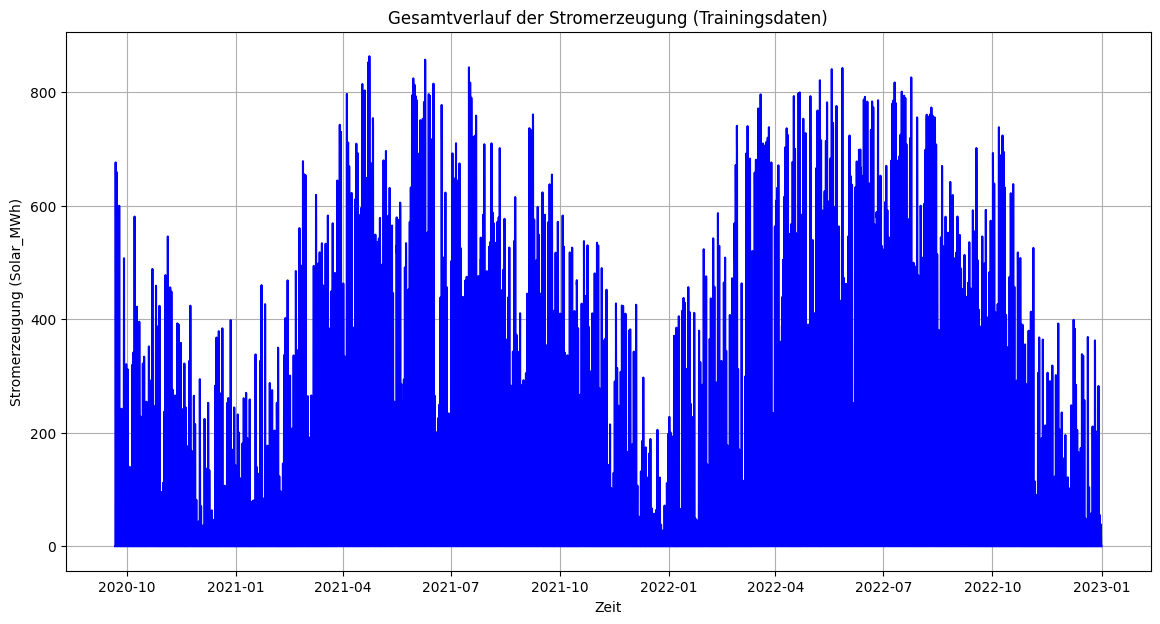

In [68]:
# 3. Gesamtverlauf visualisieren
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(df_train["dtm"]), df_train["Solar_MWh"], color="blue")
plt.xlabel("Zeit")
plt.ylabel("Stromerzeugung (Solar_MWh)")
plt.title("Gesamtverlauf der Stromerzeugung (Trainingsdaten)")
plt.grid()
plt.show()

Im Sommer steigt die Stromerzeugung, da es länger hell bleibt und wenig Wolkenbedeckung hat. <br>
Im Winter sinkt die Stromerzeugung, da es schneller dunkel wird und weniger Sonnenschein tagsüber hat.

# Aufgabe 2 Merge und Untersuchung von Zusammenhänge

In [70]:
# Transformiere "ref_datetime" und "dtm" zu datetime
df_train["ref_datetime"] = pd.to_datetime(df_train["ref_datetime"])
df_train["dtm"] = pd.to_datetime(df_train["dtm"])
df_forecasts["ref_datetime"] = pd.to_datetime(df_forecasts["ref_datetime"])

# Gültigen Zeitpunkt für Wettervorhersagen berechnen
df_forecasts["valid_datetime"] = df_forecasts["ref_datetime"] + pd.to_timedelta(df_forecasts["valid_time"], unit="h")

df_merged = pd.merge(
    df_train,
    df_forecasts,
    left_on=["dtm", "ref_datetime"],
    right_on=["valid_datetime", "ref_datetime"],
    how="inner"
)

In [71]:
df_merged

,dtm,ref_datetime,Solar_capacity_mwp,Solar_MWh,valid_time,SolarDownwardRadiation,CloudCover,Temperature,Weather Model,valid_datetime
0,2020-09-21 00:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,24,-0.008356,0.327759,12.216522,DWD ICON,2020-09-21 00:00:00+00:00
1,2020-09-21 00:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,24,0.000000,0.002000,12.240011,NCEP GFS,2020-09-21 00:00:00+00:00
2,2020-09-21 01:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,25,0.008838,0.436067,12.015985,DWD ICON,2020-09-21 01:00:00+00:00
3,2020-09-21 01:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,25,0.000000,0.003000,12.032483,NCEP GFS,2020-09-21 01:00:00+00:00
4,2020-09-21 02:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,26,0.015384,0.468752,11.813635,DWD ICON,2020-09-21 02:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...
39559,2022-12-31 21:00:00+00:00,2022-12-30 18:00:00+00:00,2212.678300,0.0,27,0.000000,1.000000,12.386409,NCEP GFS,2022-12-31 21:00:00+00:00
39560,2022-12-31 22:00:00+00:00,2022-12-30 18:00:00+00:00,2212.678300,0.0,28,-0.006250,0.999715,11.612177,DWD ICON,2022-12-31 22:00:00+00:00
39561,2022-12-31 22:00:00+00:00,2022-12-30 18:00:00+00:00,2212.678300,0.0,28,0.000000,1.000000,12.532788,NCEP GFS,2022-12-31 22:00:00+00:00
39562,2022-12-31 23:00:00+00:00,2022-12-30 18:00:00+00:00,2237.476835,0.0,29,0.002148,1.000000,11.141291,DWD ICON,2022-12-31 23:00:00+00:00


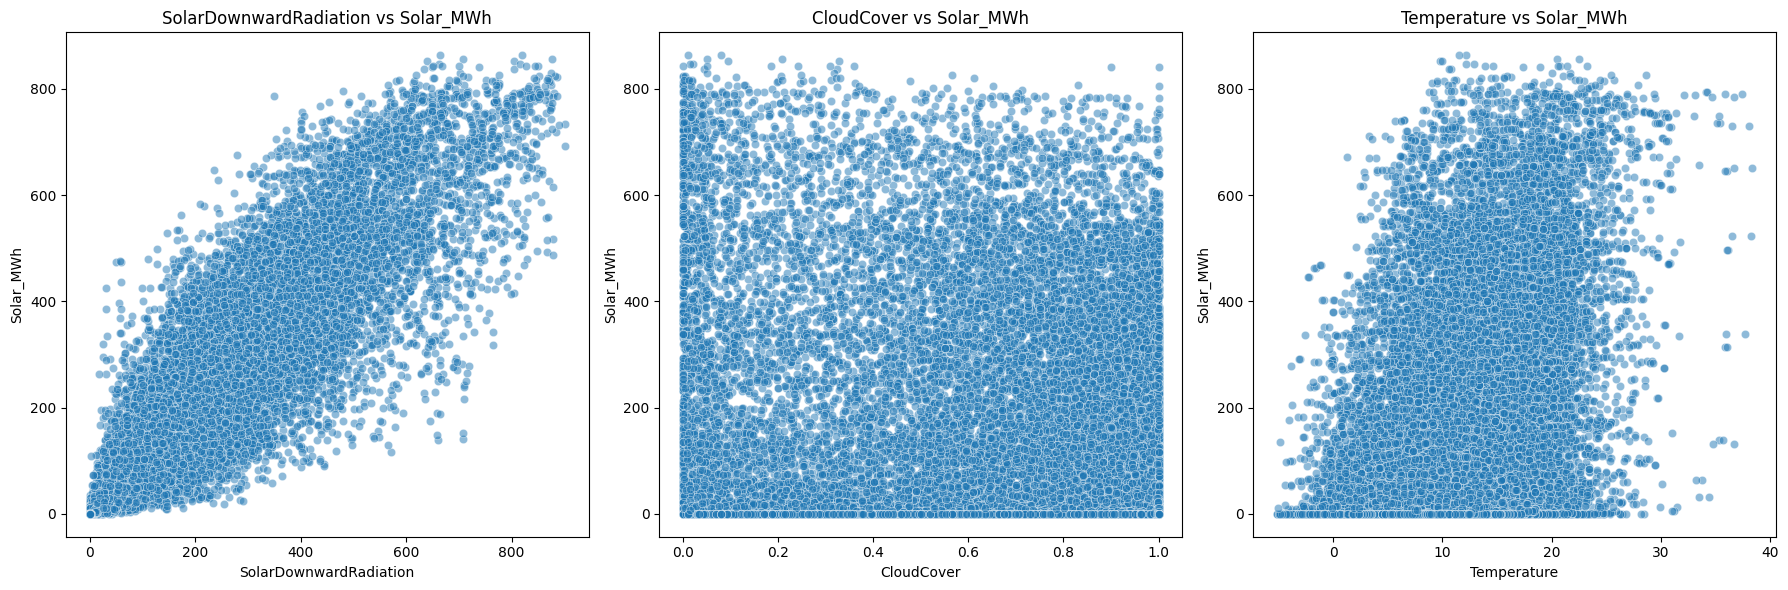

In [ ]:
# 1.Plot erstellen
# Scatterplots für jede Wettervariable vs. Solar_MWh
weather_attributes = ["SolarDownwardRadiation", "CloudCover", "Temperature"]

plt.figure(figsize=(18, 6))
for i, attr in enumerate(weather_attributes):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(data=df_merged, x=attr, y="Solar_MWh", alpha=0.5)
    plt.title(f"{attr} vs Solar_MWh")
    plt.xlabel(attr)
    plt.ylabel("Solar_MWh")
plt.tight_layout()
plt.show()

In [74]:
# 2. Erkennung von Zusammenhängen
# Korrelationen zwischen Wetterattributen und Solar_MWh berechnen
correlations = df_merged[weather_attributes + ["Solar_MWh"]].corr()["Solar_MWh"].sort_values(ascending=False)
print("Korrelationen mit Solar_MWh:")
print(correlations)

Korrelationen mit Solar_MWh:
Solar_MWh                 1.000000
SolarDownwardRadiation    0.929823
Temperature               0.423761
CloudCover               -0.101712
Name: Solar_MWh, dtype: float64


Die Wolkenbedeckung weißt auf einen schwachen Zusammenhang zur Stromerzeugung, während die Sonneneinstrahlung wichtiger ist.